In [1]:
import time
import random
import os
import matplotlib.pyplot as plt
import argparse
import string

import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf
from skimage import exposure

from mxnet import nd, autograd, gluon
from mxboard import SummaryWriter
from mxnet.gluon.model_zoo.vision import resnet34_v1
np.seterr(all='raise')

import multiprocessing
mx.random.seed(1)

from utils.iam_dataset import IAMDataset
from utils.draw_text_on_image import draw_text_on_image

max_seq_len = 100
print_every_n = 5
save_every_n = 50
send_image_every_n = 10

alphabet_encoding = string.ascii_letters+string.digits+string.punctuation+' '
alphabet_dict = {alphabet_encoding[i]:i for i in range(len(alphabet_encoding))}

## Network definition
Define a CNN-biLSTM for handwriting recognition.
Image features at two levels were obtained from a truncated Resnet34 and downsampled with a simple CNN. 
The 2 sets of image features were fed into two separate biLSTM for handwriting recognition. 

In [2]:
class EncoderLayer(gluon.Block):
    def __init__(self, hidden_states=200, lstm_layers=1, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.lstm = mx.gluon.rnn.LSTM(hidden_states, lstm_layers, bidirectional=True)
            
    def forward(self, x):
        x = x.transpose((0, 3, 1, 2))
        x = x.flatten()
        x = x.split(num_outputs=max_seq_len, axis=1) # (SEQ_LEN, N, CHANNELS)
        x = nd.concat(*[elem.expand_dims(axis=0) for elem in x], dim=0)
        x = self.lstm(x)
        x = x.transpose((1, 0, 2)) #(N, SEQ_LEN, HIDDEN_UNITS)
        return x

class Network(gluon.Block):
    def __init__(self, num_downsamples=2, resnet_layer_id=4, lstm_hidden_states=200, lstm_layers=1, **kwargs):
        super(Network, self).__init__(**kwargs)
        self.p_dropout = 0.5
        self.num_downsamples = num_downsamples
        self.body = self.get_body(resnet_layer_id=resnet_layer_id)

        self.encoders = gluon.nn.Sequential()
        
        for _ in range(self.num_downsamples):
            encoder = self.get_encoder(lstm_hidden_states=lstm_hidden_states, lstm_layers=lstm_layers)
            self.encoders.add(encoder)
        self.decoder = self.get_decoder()
        self.downsampler = self.get_down_sampler(64)

    def get_down_sampler(self, num_filters):
        '''
        Creates a two-stacked Conv-BatchNorm-Relu and then a pooling layer to
        downsample the image features by half.
        '''
        out = gluon.nn.HybridSequential()
        for _ in range(2):
            out.add(gluon.nn.Conv2D(num_filters, 3, strides=1, padding=1))
            out.add(gluon.nn.BatchNorm(in_channels=num_filters))
            out.add(gluon.nn.Activation('relu'))
        out.add(gluon.nn.MaxPool2D(2))
        out.collect_params().initialize(mx.init.Normal(), ctx=ctx)
        out.hybridize()
        return out

    def get_body(self, resnet_layer_id):
        '''
        Create the feature extraction network of the SSD based on resnet34.
        The first layer of the res-net is converted into grayscale by averaging the weights of the 3 channels
        of the original resnet.

        Returns
        -------
        network: gluon.nn.HybridSequential
            The body network for feature extraction based on resnet
        '''
        
        pretrained = resnet34_v1(pretrained=True, ctx=ctx)
        pretrained_2 = resnet34_v1(pretrained=True, ctx=mx.cpu(0))
        first_weights = pretrained_2.features[0].weight.data().mean(axis=1).expand_dims(axis=1)
        # First weights could be replaced with individual channels.
        
        body = gluon.nn.HybridSequential()
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Normal(), ctx=ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:-resnet_layer_id])
        return body

    def get_encoder(self, lstm_hidden_states, lstm_layers):
        encoder = gluon.nn.Sequential()
        encoder.add(EncoderLayer(hidden_states=lstm_hidden_states, lstm_layers=lstm_layers))
        encoder.add(gluon.nn.Dropout(self.p_dropout))
        encoder.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
        return encoder
    
    def get_decoder(self):
        alphabet_size = len(string.ascii_letters+string.digits+string.punctuation+' ') + 1
        decoder = mx.gluon.nn.Dense(units=alphabet_size, flatten=False)
        decoder.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
        return decoder

    def forward(self, x):
        features = self.body(x)
        hidden_states = []
        hs = self.encoders[0](features)
        hidden_states.append(hs)
        for i, _ in enumerate(range(self.num_downsamples - 1)):
            features = self.downsampler(features)
            hs = self.encoders[i+1](features)
            hidden_states.append(hs)
        hs = nd.concat(*hidden_states, dim=2)
        output = self.decoder(hs)
        return output

### Helper functions to train the network 

In [3]:
def transform(image, label):
    image = skimage_tf.resize(image, (30, 400), mode='constant')
    image = np.expand_dims(image, axis=0).astype(np.float32)
    if image[0, 0, 0] > 1:
        image = image/255.
    
    label_encoded = np.zeros(max_seq_len, dtype=np.float32)-1
    # i = 0
    # for letter in label[0]:
    #     label_encoded[i] = alphabet_dict[letter]
    #     i += 1

    i = 0
    for word in label:
        # if i >= max_seq_len:
        #     break
        for letter in word:
            label_encoded[i] = alphabet_dict[letter]   
            i += 1
    return image, label_encoded

def augment_transform(image, label):
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)

    sx = random.uniform(1. - random_y_scaling, 1. + random_y_scaling)
    sy = random.uniform(1. - random_x_scaling, 1. + random_x_scaling)

    s = random.uniform(-random_shearing, random_shearing)

    st = skimage_tf.AffineTransform(scale=(sx, sy),
                                    shear=s,
                                    translation=(tx*image.shape[1], ty*image.shape[0]))
    augmented_image = skimage_tf.warp(image, st, cval=1.0)
    return transform(augmented_image*255., label)

In [4]:
def decode(prediction):
    results = []
    for word in prediction:
        result = []
        for i, index in enumerate(word):
            if i < len(word) - 1 and word[i] == word[i+1] and word[-1] != -1: #Hack to decode label as well
                continue
            if index == len(alphabet_dict) or index == -1:
                continue
            else:
                result.append(alphabet_encoding[int(index)])
        results.append(result)
    words = [''.join(word) for word in results]
    return words

In [5]:
def run_epoch(e, network, dataloader, trainer, log_dir, print_name, update_network, save_network):
    total_loss = nd.zeros(1, ctx)
    for i, (x, y) in enumerate(dataloader):
        x = x.as_in_context(ctx)
        y = y.as_in_context(ctx)

        with autograd.record():
            output = network(x)
            loss_ctc = ctc_loss(output, y)

        if update_network:
            loss_ctc.backward()
            trainer.step(x.shape[0])

        if i == 0 and e % send_image_every_n == 0 and e > 0:
            predictions = output.softmax().topk(axis=2).asnumpy()
            decoded_text = decode(predictions)
            output_image = draw_text_on_image(x.asnumpy(), decoded_text)
            print("{} first decoded text = {}".format(print_name, decoded_text[0]))
            with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
                sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)

        total_loss += loss_ctc.mean()

    epoch_loss = float(total_loss.asscalar())/len(dataloader)

    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {print_name: epoch_loss}, global_step=e)

    if save_network and e % save_every_n == 0 and e > 0:
        network.save_parameters("{}/{}".format(checkpoint_dir, checkpoint_name))

    return epoch_loss

In [6]:
ctx = mx.gpu(0)

epochs = 120
learning_rate = 0.0001
batch_size = 32

num_downsamples = 2
resnet_layer_id = 4
lstm_hidden_states = 200
lstm_layers = 1

random_y_translation, random_x_translation = 0.03, 0.03
random_y_scaling, random_x_scaling = 0.1, 0.1
random_shearing = 0.5

log_dir = "./logs"
checkpoint_dir = "model_checkpoint"
checkpoint_name = "handwriting.params"

In [7]:
train_ds = IAMDataset("line", output_data="text", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("line", output_data="text", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

train_data = gluon.data.DataLoader(train_ds.transform(augment_transform), batch_size, shuffle=True, last_batch="discard")
test_data = gluon.data.DataLoader(test_ds.transform(transform), batch_size, shuffle=False, last_batch="discard")#, num_workers=multiprocessing.cpu_count()-2)

Number of training samples: 7998
Number of testing samples: 1860


### Training

In [9]:
net = Network(num_downsamples=num_downsamples, resnet_layer_id=resnet_layer_id , lstm_hidden_states=lstm_hidden_states, lstm_layers=lstm_layers)
net.hybridize()

trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})

ctc_loss = gluon.loss.CTCLoss(weight=0.2)

for e in range(epochs):
    train_loss = run_epoch(e, net, train_data, trainer, log_dir, print_name="train", 
                           update_network=True, save_network=True)
    test_loss = run_epoch(e, net, test_data, trainer, log_dir, print_name="test", 
                          update_network=False, save_network=False)
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

Epoch 5, train_loss 15.813505, test_loss 15.413475
train first decoded text = hircas on harger wstalhistmients the pts
test first decoded text = laas sy.' mee wre s surmaus anarn, mauin.qou;,mwoy,yoe
Epoch 10, train_loss 11.933410, test_loss 12.285030
Epoch 15, train_loss 10.490009, test_loss 10.838541
train first decoded text = abempt to appy a stiding scake to the
test first decoded text = laas dr.! mee wuve s seumnows conenne, naine&quo;h,wee o
Epoch 20, train_loss 9.598322, test_loss 10.230093
Epoch 25, train_loss 8.991188, test_loss 9.565433
train first decoded text = burivet no focd feosge would vever caneal hem
test first decoded text = (aas wes. Imae Wwee s suirnouws canern, nouin.qot;In o , ot
Epoch 30, train_loss 8.492390, test_loss 9.194014
Epoch 35, train_loss 8.081608, test_loss 8.914980
train first decoded text = Ccometed by the sliding sabe of the secand poel-tar,
test first decoded text = Maas eay., I mse wure s surnows onern, mauin.&qot;I, o , o
Epoch 40, train_loss 7.

# Results
Visually inspect the results

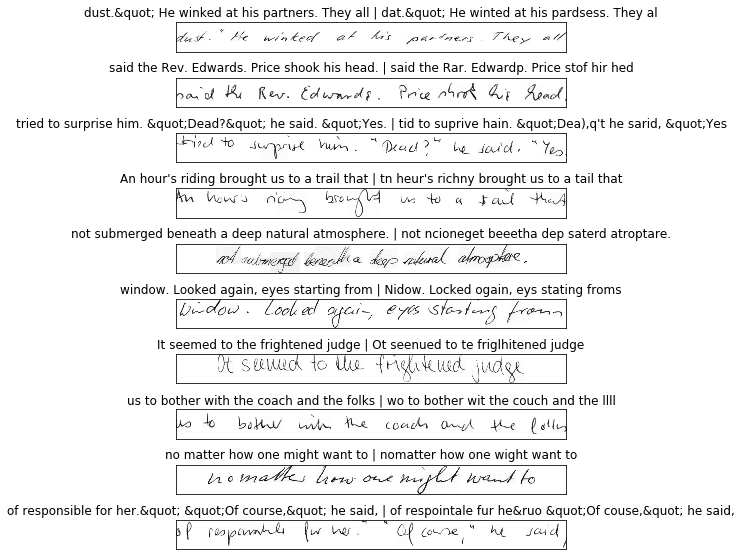

In [10]:
figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, figsize=(7, figs_to_plot))

for i in range(figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, actual_label = test_ds[n]

    image, _ = transform(image, actual_label)

    image = nd.array(image)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    output = net(image)
    predictions = output.softmax().topk(axis=2).asnumpy()
    decoded_prediction_text = decode(predictions)[0]
    axs[i].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    axs[i].set_title("{} | {}".format(actual_label[0], decoded_prediction_text))
    axs[i].tick_params(axis='both',       
                       which='both',      
                       bottom=False,      
                       top=False,         
                       left=False,
                       right=False,
                       labelleft=False,
                       labelbottom=False) 
